# Tutorial02: Evaluate $D(x)$ using ROC and AUC
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction

In the notebook `tutorial01`, we built a simple **discriminant** $D(x)$ to classify the points $x \in \mathbb{R}^2$ sampled from two known Gaussians. In this notebook we compare the approximate discriminant to the exact one using two measures: the **Receiver Operating Characteristic** (ROC) curve and the **Area Under the (ROC) Curve** (AUC). The exact discriminant is given by 
\begin{align}
    D(x) & = \frac{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)})}{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)}) + \mathcal{N}(x, \mu^{(0)}, \Sigma^{(0)})},
\end{align}
where $\mathcal{N}(x, \mu, \Sigma)$ is the probability density function (pdf) of a bivariate Gaussian.

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
BASE = '../../Lab01' # base location of model

MODELFILE = f'{BASE:s}/code/nnmodel.dict' # file containing parameters of trained model

INPUTS = ['x1', 'x2']

TARGET = 'target'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Exact density

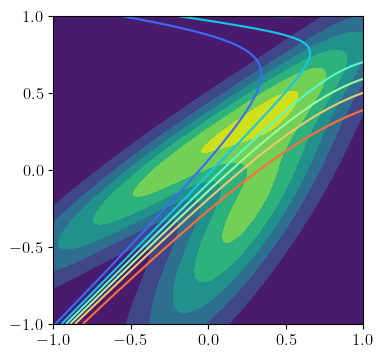

(101, 101)

In [3]:
# update paths searched by Python to find packages/modules

sys.path.append(f'{BASE:s}/code')

from exactdensity import ExactDensity

fexact = ExactDensity()
x1, x2 = fexact.grid()

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)

tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_xticks(tickmarks)
ax.set_yticks(tickmarks)

ax.contourf(x1, x2, fexact(x1, x2))

pexact = fexact.prob(x1, x2)
ax.contour(x1, x2, pexact, cmap='rainbow')
plt.show()

pexact.shape

## Load trained (i.e., fitted) model

In [4]:
from nnmodel import model

model.load_state_dict(torch.load(MODELFILE))

model

Sequential(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): SiLU()
  (2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=15, out_features=15, bias=True)
  (4): SiLU()
  (5): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=15, out_features=15, bias=True)
  (7): SiLU()
  (8): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=15, out_features=1, bias=True)
  (10): Sigmoid()
)

## Load test data
(Moved testdata.csv to Lab02/data)

In [5]:
test_data = pd.read_csv('../data/testdata.csv')

print(len(test_data))

test_data[:5]

15000


,x1,x2,target
0,-0.458884,-1.324906,1.0
1,0.480855,0.465076,0.0
2,0.907871,0.937647,1.0
3,0.469942,0.002835,1.0
4,0.452462,0.345677,1.0


## Compute approximate discriminant values

In [6]:
X = test_data[INPUTS].to_numpy()
Y = test_data[TARGET].to_numpy()

X.shape, Y.shape

((15000, 2), (15000,))

In [7]:
x = torch.tensor(X).float() # need to use float32 numbers not float64

Dapprox = model(x).detach().numpy().flatten()

Dapprox.shape

(15000,)

## Compute exact discriminant values

In [8]:
fexact = ExactDensity()

X1 = X[:, 0] # extract all rows (:) of column 0
X2 = X[:, 1] # extract all rows (:) of column 1

Dexact = fexact.prob(X1, X2)

Dexact.shape

(15000,)

## Plot distributions of discriminant values
What we are doing here is approximating the densities

\begin{align}
    p(D | 0) & = \int_{\mathbb{R}^2} \delta(D - f(x)) \, p(x | 0) \, dx, \\
    p(D | 1) & = \int_{\mathbb{R}^2} \delta(D - f(x)) \, p(x | 1) \, dx,
\end{align}

using histograms.

In [9]:
def plot_distribution(D, y, 
                      nbins=100, 
                      ftsize=FONTSIZE, 
                      fgsize=(5, 3.5)):

    # select "signal"
    s = D[y > 0.5]
    
    # select "background"
    b = D[y < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.xlabel('$D(x)$')
    
    plt.yscale('log')
    plt.ylabel('$p(D|k), k=0, 1$')
    
    plt.hist(b, 
             bins=nbins, 
             color='red',
             alpha=0.3,
             range=(0, 1), 
             density=True, 
             label='background') 
    plt.legend(fontsize='small')
    
    plt.hist(s, 
             bins=nbins, 
             color='blue',
             alpha=0.3,
             range=(0, 1), 
             density=True, 
             label='signal')
    plt.legend(fontsize='small')

    plt.savefig("D_distribution.png")
    plt.show()

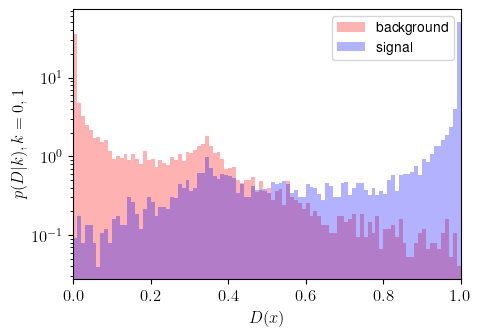

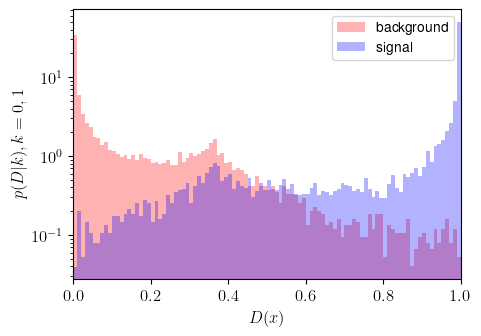

In [10]:
plot_distribution(Dexact, Y)
plot_distribution(Dapprox, Y)

## Now compute ROC and AUC

First compute

\begin{align}
    f_k(D) & = \int_{z=D}^{z=1} p(z | k) \, dz,\quad k = 0, 1,
\end{align}

The ROC curve is $f_1(D) \text{ vs. } f_0(D)$ and the AUC is simply the area beneath it.

In [11]:
# standard measures of model performance
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, D):
    
    bkg, sig, _ = roc_curve(y, D)
    
    roc_auc = auc(bkg, sig)
    plt.figure(figsize=(3.5, 3.5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$f_0(D)$', fontsize=12)
    plt.ylabel('$f_1(D)$', fontsize=12)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    
    plt.savefig("ROC.png")
    plt.show()

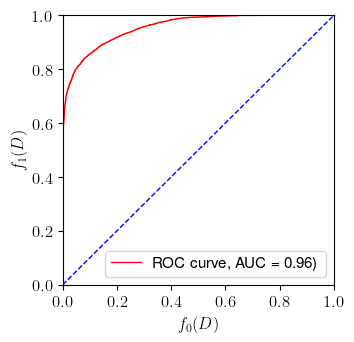

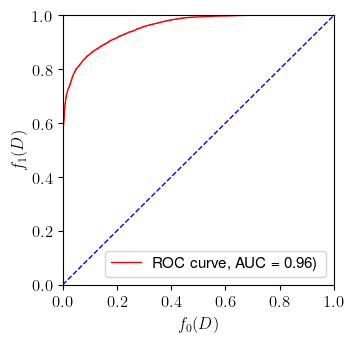

In [12]:
plot_ROC(Y, Dexact)
plot_ROC(Y, Dapprox)